In [2]:
from langchain_anthropic import ChatAnthropic
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage

from typing import TypedDict, List, Annotated, Literal, Union
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
import operator

from langgraph.types import Command, Send
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

from pydantic import BaseModel, Field
from typing import List, Literal, Dict, Any
from enum import Enum

import uuid

from tavily import TavilyClient

from dotenv import load_dotenv

load_dotenv()

True

In [3]:
def init_llm(
        provider: Literal["openai", "anthropic", "google", "ollama"],
        model: str,
        temperature: float = 0.5,
):
    if provider == "openai":
        return ChatOpenAI(model=model, temperature=temperature)
    elif provider == "anthropic":
        return ChatAnthropic(model=model, temperature=temperature)
    elif provider == "google":
        return ChatGoogleGenerativeAI(model=model, temperature=temperature)
    elif provider == "ollama":
        return ChatOllama(model=model, temperature=temperature)

In [4]:
llm = init_llm(
    provider="openai",
    model="gpt-4o-mini",
    temperature=0.5
)

In [5]:
class FieldType(str, Enum):
    string = "string"
    number = "number"
    array = "array"
    boolean = "boolean"

class SchemaField(BaseModel):
    key: str = Field(..., description="The unique identifier for the field")
    type: FieldType = Field(..., description="The data type of the field")
    description: str = Field(..., description="Some descriptive information for the field")

class DatasetSchema(BaseModel):
    generated_schema: list[SchemaField]

class DatasetRecords(BaseModel):
    dataset: List[Dict[str, Any]]

In [6]:
class Section(BaseModel):
    section_name: str = Field(..., description="The name of this section of the report without its number")
    sub_sections: List[str] = Field(..., description="Comprehensive descriptions of sub-sections, each combining the sub-section title and its bullet points into a fluid, natural-language description")

class Sections(BaseModel):
    sections: List[Section] = Field(..., description="A list of sections")

class Query(BaseModel):
    query: str = Field(..., description="A search query")

class Queries(BaseModel):
    queries: List[Query] = Field(..., description="A list of search queries")

class SearchResult(BaseModel):
    query: Query = Field(..., description="The search query that was used to retrieve the raw content")
    raw_content: list[str] = Field(..., description="The raw content retrieved from the search")

class Feedback(BaseModel):
    feedback: Union[str, bool] = Field(..., description="Feedback on the report structure. If the content is good for the section, return True (boolean), otherwise return a string of feedback on what is missing or incorrect.")

class SectionOutput(BaseModel):
    # final_section_content: List[str] = Field(..., description="The final section content")
    final_section_dataset: List[Dict[str, Any]] = Field(..., description="The final section dataset")

In [7]:
class AgentState(TypedDict):
    topic: str
    outline: str
    messages: Annotated[List[BaseMessage], operator.add]
    report_structure: str
    sections: List[Section]
    final_section_dataset: Annotated[List[Dict[str, Any]], operator.add] = []
    final_dataset: List[Dict[str, Any]]
    schema: DatasetSchema

class ResearchState(TypedDict):
    topic: str
    report_structure: str
    section: Section
    knowledge: str
    reflection_feedback: Feedback = Feedback(feedback="")
    generated_queries: List[Query] = []
    searched_queries: Annotated[List[Query], operator.add] = []
    search_results: Annotated[List[SearchResult], operator.add] = []
    accumulated_content: str = ""
    reflection_count: int = 1
    final_section_content: List[str] = []
    schema: DatasetSchema
    final_section_dataset: List[Dict[str, Any]] = []
    error: str

In [8]:
SCHEMA_GENERATION_PROMPT = """You are an autonomous schema-generating agent designed to construct data schemas for fine-tuning or training LLMs on user-specified tasks. Your jobis to analyze the user's task description and output a structured dataset schema definition.

Ensure each field in the schema is useful for training and fine-tuning, well-typed, and annotated. Focus on tasks involving natural language input, structured context (like database schemas), and model output (like SQL queries, code, responses, etc.).
"""

In [ ]:
dataset_schema_generator_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(SCHEMA_GENERATION_PROMPT),
    HumanMessagePromptTemplate.from_template(
        template="""
        Topic: {topic}
        Outline: {outline}
        """
    ),
    MessagesPlaceholder(variable_name="messages")
])

llm_with_schema_tool = llm.bind_tools(tools=[DatasetSchema], tool_choice="required")
schema_generator_llm = dataset_schema_generator_system_prompt | llm_with_schema_tool

def schema_generator_node(state: AgentState, config: RunnableConfig):
    result = schema_generator_llm.invoke(state)
    suggested_schema = DatasetSchema.model_validate(result.tool_calls[0]["args"])

    return {"schema": suggested_schema, "messages": f"{[suggested_schema.generated_schema]}"}

In [10]:
def human_feedback_on_schema_node(state: AgentState, config: RunnableConfig) -> Command[Literal["report_structure_planner", "schema_generator"]]:
    human_message = input("Please provide feedback on the report structure (type 'continue' to continue): ")
    schema = state.get("schema")
    if human_message == "continue":
        return Command(
            goto="report_structure_planner",
            update={"messages": [HumanMessage(content=human_message)], "schema": schema}
        )
    else:
        return Command(
            goto="schema_generator",
            update={"messages": [HumanMessage(content=human_message)]}
        )

In [11]:
REPORT_STRUCTURE_PLANNER_SYSTEM_PROMPT_TEMPLATE = """You are an expert research assistant specialized in creating structured research frameworks. Your primary task is to generate a detailed, appropriate report structure based on a user's research topic and brief outline.

## Process to Follow:

1. UNDERSTAND THE REQUEST:
   - Carefully analyze the topic and outline provided by the user
   - Identify the type of research needed (exploratory, comparative, analytical, etc.)
   - Recognize the domain/field of the research

2. ASK CLARIFYING QUESTIONS:
   - If the user's request lacks sufficient detail, ask 2-3 focused questions to better understand:
     * Their background and expertise level
     * Their specific goals for the research
     * Any particular aspects they want to emphasize
     * Intended audience and purpose of the report
   - Prioritize questions that will significantly impact the report structure

3. GENERATE A COMPREHENSIVE REPORT STRUCTURE:
   - Create a detailed, hierarchical structure with:
     * Clear main sections (typically 5-12 depending on topic complexity)
     * Relevant subsections under each main section
     * Logical flow from introduction to conclusion
   - Adapt the structure to match the specific research type:
     * For learning/exploration topics: progress from fundamentals to advanced concepts
     * For comparison topics: use parallel structure across compared items
     * For data source exploration: organize by data types, sources, and methodologies
     * For implementation topics: follow a logical sequence from setup to advanced usage
   - Ensure the structure is comprehensive but focused on the user's specific needs

4. FORMAT THE RESPONSE:
   - Present the report structure as a hierarchical outline with clear section numbering
   - Use descriptive titles for each section and subsection
   - Include brief descriptions of key sections when helpful
   - Provide the structure in a clean, easy-to-read format

5. OFFER FOLLOW-UP ASSISTANCE:
   - Ask if any sections need adjustment or elaboration
   - Suggest specific modifications if you identify potential improvements

Remember that your task is ONLY to create the report structure, not to produce the actual research content. Focus on creating a comprehensive framework that will guide the user's research efforts.
"""

In [12]:
report_structure_planner_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(REPORT_STRUCTURE_PLANNER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(
        template="""
        Topic: {topic}
        Outline: {outline}
        """
    ),
    MessagesPlaceholder(variable_name="messages")
])

report_structure_planner_llm = report_structure_planner_system_prompt | llm

def report_structure_planner_node(state: AgentState, config: RunnableConfig):
    result = report_structure_planner_llm.invoke(state)
    return {"messages": [result]}

In [13]:
def human_feedback_node(state: AgentState, config: RunnableConfig)->Command[Literal["section_formatter", "report_structure_planner"]]:
    human_message = input("Please provide feedback on the report structure (type 'continue' to continue): ")
    report_structure = state.get("messages")[-1].content
    if human_message == "continue":
        return Command(
            goto="section_formatter",
            update={"messages": [HumanMessage(content=human_message)], "report_structure": report_structure}
        )
    else:
        return Command(
            goto="report_structure_planner",
            update={"messages": [HumanMessage(content=human_message)]}
        )

In [14]:
SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE = """You are a specialized parser that converts hierarchical report structures into a structured format. Your task is to analyze a report structure outline and extract the sections and subsections, while condensing the detailed bullet points into comprehensive subsection descriptions.

## Your Input:
You will receive a message containing a report structure with numbered sections and subsections, along with descriptive bullet points.

## Your Output Format:
You must output the result in the presented structure

# Processing Instructions:

- Identify each main section (typically numbered as 1, 2, 3, etc.)
- Extract the main section title without its number (e.g., "Introduction" from "1. Introduction")
- For each main section, identify all its subsections (typically numbered as 1.1, 1.2, 2.1, 2.2, etc.)
- For each subsection, incorporate its title AND the descriptive bullet points beneath it into a single comprehensive description
- Combine related concepts using commas and connecting words (and, with, including, etc.)
- Organize these into a JSON array with each object containing:
  "section_name": The main section title
  "sub_sections": An array of comprehensive subsection descriptions

# Content Condensation Guidelines:

- Transform subsection titles and their bullet points into fluid, natural-language descriptions
- Include all key concepts from the bullet points, but phrase them as part of a cohesive description
- Use phrases like "overview of", "including", "focusing on", "covering", etc. to connect concepts
- Maintain the key terminology from the original structure
- Aim for descriptive phrases rather than just lists of topics

# Example Transformation:
## From:
1. Introduction
   - 1.1 Background of Machine Learning
     - Overview of machine learning concepts
     - Importance of algorithms in machine learning
   - 1.2 Introduction to Support Vector Machines
     - Definition and significance
     - Historical context and development
To:
{{
  "section_name": "Introduction",
  "sub_sections": [
    "Background, overview and importance of Machine Learning", 
    "Introduction to Support Vector Machines, definition, significance and historical context"
  ]
}}

Remember to output only the valid JSON array containing all processed sections, with no additional commentary or explanations in your response.
"""

In [15]:

section_formatter_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{report_structure}"),
])

section_formatter_llm = section_formatter_system_prompt | llm.with_structured_output(Sections)

def section_formatter_node(state: AgentState, config: RunnableConfig) -> Command[Literal["research_agent"]]:
    result = section_formatter_llm.invoke(state)
    schema = state.get("schema")
    report_structure = state.get("report_structure")
    topic = state.get("topic")
    # return {"sections": result.sections}
    return Command(
        update={"sections": result.sections},
        goto=[
            Send(
                "research_agent",
                {
                    "topic": topic,
                    "section": s,
                    "schema": schema,
                    "report_structure": report_structure,
                }
            ) for s in result.sections
        ]
    )

In [16]:
SECTION_KNOWLEDGE_SYSTEM_PROMPT_TEMPLATE = """You are an expert research content generator. Your task is to create comprehensive, accurate, and well-structured content for a specific section of a research report. You will be provided with a section name and its subsections, and you should use your knowledge to create detailed content covering all aspects described.

## Input Format:
You will receive a section object with the following structure:
```json
{{
  "section_name": "The main section title",
  "sub_sections": [
    "Comprehensive description of subsection 1 including key points to cover",
    "Comprehensive description of subsection 2 including key points to cover",
    ...
  ]
}}
```

## Your Task:
Generate thorough, accurate content for this section that:

1. Begins with a brief introduction to the section topic
2. Covers each subsection in depth, maintaining the order provided
3. Includes relevant examples, explanations, and context
4. Incorporates current understanding and established knowledge on the topic
5. Maintains an academic and informative tone appropriate for a research report
6. Uses appropriate headings and subheadings for structure

## Content Guidelines:

### Depth and Breadth:
- Aim for comprehensive coverage of each subsection
- Include definitions of key terms and concepts
- Discuss current understanding and applications
- Address relationships between different concepts

### Structure:
- Use hierarchical formatting with clear headings
- Format the section title as a level 2 heading (##)
- Format each subsection as a level 3 heading (###)
- Use paragraphs to organize information logically
- Include transitional phrases between subsections

### Content Quality:
- Prioritize accuracy and clarity
- Provide specific examples to illustrate concepts
- Include relevant data points, statistics, or findings when applicable
- Maintain an objective, scholarly tone
- Avoid oversimplification of complex topics

### Technical Considerations:
- Use markdown formatting for headings, lists, and emphasis
- Include appropriate technical terminology
- Define specialized terms when they first appear
- Use code snippets or mathematical notation if appropriate for the topic

## Output Format:
Return only the generated content with appropriate markdown formatting. Do not include meta-commentary about your process or limitations. Your output should be ready to be inserted directly into the research report as a complete section.

Remember to rely solely on your existing knowledge. Do not fabricate specific studies, statistics, or quotations that you cannot verify.
"""

In [17]:
section_knowledge_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(SECTION_KNOWLEDGE_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{section}"),
])

section_knowledge_llm = section_knowledge_system_prompt | llm

def section_knowledge_node(state: ResearchState, config: RunnableConfig):
    result = section_knowledge_llm.invoke(state)
    return {"knowledge": result.content}

In [18]:
QUERY_GENERATOR_SYSTEM_PROMPT_TEMPLATE = """You are a specialized search query generator for a research assistant system. Your task is to create highly effective search queries based on research section information. These queries will be used to retrieve relevant information from web search APIs to enhance research report content.

## Section Structure:
```json
{{
  "section_name": "The main section title",
  "sub_sections": [
    "Comprehensive description of subsection 1 including key points to cover",
    "Comprehensive description of subsection 2 including key points to cover",
    ...
  ]
}}
```

## Your Task:
Generate up to {max_queries} effective search queries that will retrieve the most relevant information for the given section and its subsections.

## Query Generation Process:

### For Initial Runs (no previous_queries or reflection_feedback):
1. Analyze the section name and all subsection descriptions thoroughly
2. Identify the core concepts, key terms, and relationships that need to be researched
3. Prioritize fundamental information needs first
4. Create specific, targeted queries for the most important information
5. Ensure coverage across all subsections, but prioritize depth over breadth
6. Include technical terminology and domain-specific language when appropriate

### For Subsequent Runs (with reflection_feedback):
1. Carefully analyze the reflection feedback to understand information gaps
2. Prioritize queries that address the specific missing information
3. Avoid generating queries too similar to previous_queries
4. Create more specialized or alternative phrasings to find the missing information
5. Use more technical or specific terminology if general queries were insufficient

## Query Construction Guidelines:

1. **Specificity**: Create targeted queries that are likely to return relevant results
   - Include specific technical terms rather than general descriptions
   - Incorporate domain knowledge and specialized terminology

2. **Diversity**: Ensure variety in your query approaches
   - Vary query structure (questions, keyword sets, specific facts to verify)
   - Target different aspects of the subsections
   - Include different perspectives or viewpoints when relevant

3. **Prioritization**: Order queries by importance
   - Place queries for fundamental or critical information first
   - Prioritize queries addressing explicit reflection feedback
   - Ensure the most important subsections are covered in the limited query count

4. **Effectiveness**: Optimize for search engine performance
   - Use search operators when helpful (quotes for exact phrases, etc.)
   - Keep queries concise but descriptive (typically 4-10 words)
   - Include year/recency indicators for time-sensitive topics

Remember: The most important queries should come first in your list, as the system may only use a subset of your generated queries based on the user's `max_queries` setting.
"""

In [ ]:

def query_generator_node(state: ResearchState, config: RunnableConfig):
    query_generator_system_prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(QUERY_GENERATOR_SYSTEM_PROMPT_TEMPLATE),
        HumanMessagePromptTemplate.from_template(template="Section: {section}\nPrevious Queries: {searched_queries}\nReflection Feedback: {reflection_feedback}"),
    ])

    query_generator_llm = query_generator_system_prompt | llm.with_structured_output(Queries)
    state.setdefault("reflection_feedback", "")
    state.setdefault("searched_queries", [])
    configurable = config.get("configurable")

    input_data = {
        **state,
        **configurable  # includes max_queries, search_depth, etc.
    }

    result = query_generator_llm.invoke(input_data, configurable)
    return {"generated_queries": result.queries, "searched_queries": result.queries}


In [20]:
tavily_client = TavilyClient()

def tavily_search_node(state: ResearchState, config: RunnableConfig):
    queries = state["generated_queries"]
    configurable = config.get("configurable")
    search_results = []
    for query in queries:
        raw_content = []
        response = tavily_client.search(query=query.query, max_results=configurable.get("search_depth"), include_raw_content=True)
        for result in response["results"]:
            raw_content.append(result['content'])
        search_results.append(SearchResult(query=query, raw_content=raw_content))
    return {"search_results": search_results}

In [21]:
RESULT_ACCUMULATOR_SYSTEM_PROMPT_TEMPLATE = """You are a specialized agent responsible for curating and synthesizing raw search results. Your task is to transform unstructured web content into coherent, relevant, and organized information that can be used for report generation.

## Input
You will receive a list of SearchResult objects, each containing:
1. A Query object with the search query that was used
2. A list of raw_content strings containing text extracted from web pages

## Process
For each SearchResult provided:

1. ANALYZE the raw_content to identify:
   - Key information relevant to the associated query
   - Main concepts, definitions, and relationships
   - Supporting evidence, statistics, or examples
   - Credible sources or authorities mentioned

2. FILTER OUT:
   - Irrelevant website navigation elements and menus
   - Advertisements and promotional content
   - Duplicate information
   - Footers, headers, and other website template content
   - Form fields, subscription prompts, and UI text
   - Clearly outdated information

3. ORGANIZE the information into:
   - Core concepts and definitions
   - Key findings and insights
   - Supporting evidence and examples
   - Contrasting viewpoints (if present)
   - Contextual background information

4. SYNTHESIZE the content by:
   - Consolidating similar information from multiple sources
   - Resolving contradictions where possible (noting them explicitly otherwise)
   - Ensuring logical flow of information
   - Maintaining appropriate context

## Guidelines
- Focus on accuracy and relevance
- Maintain neutrality and balance in presenting information
- Preserve technical precision when dealing with specialized topics
- Note explicitly when information appears contradictory or uncertain
- When information appears to be from commercial sources, note potential bias
- Prioritize more recent information over older content
- Maintain proper attribution when specific sources are referenced
- NO IMPORTANT DETAILS SHOULD BE LEFT OUT. BE DETAILED AND THOROUGH.
"""

In [ ]:

def result_accumulator_node(state: ResearchState, config: RunnableConfig):
    result_accumulator_system_prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(RESULT_ACCUMULATOR_SYSTEM_PROMPT_TEMPLATE),
        HumanMessagePromptTemplate.from_template(template="{search_results}"),
    ])

    result_accumulator_llm = result_accumulator_system_prompt | llm
    result = result_accumulator_llm.invoke(state)
    return {"accumulated_content": result.content}

In [23]:
REFLECTION_FEEDBACK_SYSTEM_PROMPT_TEMPLATE = """You are a specialized agent responsible for critically evaluating search result content against report section requirements. You determine whether the accumulated content sufficiently addresses the intended section scope or requires additional information.

## Input
You will receive:
1. A Section object containing:
   - section_name: The name of the section without its number
   - sub_sections: A list of comprehensive descriptions of sub-sections
2. Accumulated content from search results related to this section

## Process
Carefully analyze the relationship between the section requirements and the accumulated content:

1. ASSESS COVERAGE by identifying:
   - How well the accumulated content addresses each sub-section
   - Key concepts or topics from the sub-sections that are missing in the content
   - Depth and breadth of information relative to what the section requires
   - Presence of all necessary perspectives, examples, and supporting evidence

2. EVALUATE QUALITY by considering:
   - Accuracy and currency of the information
   - Relevance to the specific section requirements
   - Logical organization and flow
   - Appropriate level of detail for the section's purpose
   - Balance and objectivity in presenting information

3. IDENTIFY GAPS by determining:
   - Missing key concepts or topics from the sub-sections
   - Insufficient depth in critical areas
   - Lack of supporting evidence or examples
   - Absence of important perspectives or contexts
   - Technical details required but not present

## Output
Produce a Feedback object with either:
- A boolean value of True if the content sufficiently meets the section requirements
- A string containing specific, actionable feedback on what is missing or needs improvement

## Guidelines for Feedback Generation
When providing string feedback:
- Be specific about what information is missing or inadequate
- Prioritize the most critical gaps first
- Frame feedback in a way that could guide further query generation
- Focus on content needs rather than stylistic concerns
- Indicate areas where contradictory information needs resolution
- Suggest specific types of information that would address the gaps

## Examples

Example 1 (Sufficient content):
```
True
```

Example 2 (Insufficient content):
```
"The content lacks specific examples of machine learning applications in healthcare. Additionally, there is insufficient information on the regulatory challenges of implementing AI in clinical settings. The ethical considerations sub-section requires more detailed discussion of patient privacy concerns and informed consent issues."
```

Example 3 (Partial coverage):
```
"While the general concepts of blockchain are well covered, the content is missing technical details on consensus mechanisms mentioned in sub-section 2. The comparison between proof-of-work and proof-of-stake systems is particularly needed. Additionally, more recent developments (post-2022) in scalability solutions should be included to fully address sub-section 3."
```
"""

In [24]:
reflection_feedback_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(REFLECTION_FEEDBACK_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Section: {section}\nAccumulated Content: {accumulated_content}"),
])

reflection_feedback_llm = reflection_feedback_system_prompt | llm.with_structured_output(Feedback)

def reflection_feedback_node(state: ResearchState, config: RunnableConfig) -> Command[Literal["final_section_formatter", "query_generator"]]:
    reflection_count = state.get("reflection_count", 0)
    configurable = config.get("configurable")
    result = reflection_feedback_llm.invoke(state)
    feedback = result.feedback
    if (feedback == True) or (feedback.lower() == "true") or (reflection_count < configurable.get("num_reflections")):
        return Command(
            update={"reflection_feedback": feedback},
            goto="final_section_formatter"
        )
    else:
        return Command(
            update={"reflection_feedback": feedback, "reflection_count": reflection_count + 1},
            goto="query_generator"
        )

In [25]:
FINAL_SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE = """You are a specialized agent responsible for synthesizing knowledge and research into comprehensive, authoritative section content for reports. Your task is to blend internal knowledge with curated search results to produce detailed, accurate, and well-structured section content.

## Input
You will receive:
1. Internal knowledge about the section topic (from the knowledge generator LLM)
2. Curated content from search results relevant to the section

## Process
Synthesize these information sources into cohesive section content by:

1. ANALYZE BOTH SOURCES to identify:
   - Core concepts, principles, and definitions
   - Key arguments, insights, and findings
   - Supporting evidence, examples, and case studies
   - Current trends, developments, and applications
   - Relevant controversies, debates, or alternative perspectives

2. INTEGRATE THE INFORMATION by:
   - Combining complementary information from both sources
   - Resolving any contradictions with reasoned analysis
   - Filling gaps in one source with information from the other
   - Ensuring proper flow and logical progression of ideas
   - Maintaining appropriate technical depth and precision

3. ENSURE COMPREHENSIVE COVERAGE by:
   - Addressing all key aspects of the section topic
   - Including sufficient detail on complex concepts
   - Providing necessary context for specialized information
   - Balancing breadth and depth appropriately
   - Incorporating relevant examples to illustrate key points

4. PRIORITIZE QUALITY by:
   - Favoring accuracy over quantity
   - Ensuring information is current and reflects the latest understanding
   - Presenting balanced perspectives on controversial topics
   - Maintaining appropriate technical language without unnecessary jargon
   - Supporting claims with evidence or reasoning

## Output
Produce detailed, well-structured section content that:
- Begins with a concise introduction to the topic
- Organizes information into coherent paragraphs with clear topic sentences
- Uses appropriate subheadings to improve readability and organization
- Includes relevant examples, case studies, or applications where appropriate
- Concludes with key takeaways or implications when relevant

## Guidelines
- Write in a clear, authoritative, and professional tone
- Use precise terminology appropriate to the subject matter
- Ensure logical flow between concepts and paragraphs
- Maintain appropriate technical depth based on the apparent audience level
- Include specific details, statistics, and examples where they add value
- Avoid unnecessary repetition while reinforcing key concepts
- Balance technical accuracy with readability
- Present multiple perspectives on contested topics where relevant
- Synthesize rather than merely concatenate information from the two sources
- Ensure the final content could stand alone as an authoritative resource on the topic

## Example Structure
[Section Title]

[Introductory paragraph providing overview and context]

[Subheading 1]
[Detailed exploration of first major aspect of the topic]
[Supporting evidence, examples, or case studies]

[Subheading 2]
[Detailed exploration of second major aspect of the topic]
[Supporting evidence, examples, or case studies]

[Additional subheadings as needed]

[Concluding paragraph summarizing key points and implications]"""

In [26]:
final_section_formatter_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(FINAL_SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Internal Knowledge: {knowledge}\nSearch Result content: {accumulated_content}"),
])

final_section_formatter_llm = final_section_formatter_system_prompt | llm

def final_section_formatter_node(state: ResearchState, config: RunnableConfig):
    result = final_section_formatter_llm.invoke(state)
    return {"final_section_content": result.content}

In [27]:
def process_datagen_prompt(fields: List[SchemaField], rows: int = 10) -> str:
    schema_instruction = {field.key: field.description for field in fields}

    field_string = f"""## Response Format
Always respond with a valid JSON array of objects:
[
{json.dumps(schema_instruction, indent=2)},
// Additional entries...
]
"""
    return f"""
You are an expert Question-Answer generation assistant who has the skills of a polymath. Your task is to analyze content provided by the user and generate a comprehensive set of questions with detailed answers based on that content.

## Core Instructions

1. When presented with content, carefully analyze it to identify key concepts, important details, practical applications, and potential challenges or edge cases.

2. Generate a diverse set of questions and answers that thoroughly cover the provided content. Your response must be in valid JSON format.

3. Format code properly within JSON strings, using appropriate escape characters for special characters.

4. Number of dataset rows must be {rows}

{field_string}
"""

In [28]:
import time
import json
from openai import RateLimitError, OpenAIError
from pydantic import ValidationError

def final_section_dataset_generator_node(state: ResearchState, config: RunnableConfig, max_retries: int = 3, base_wait: float = 2.0):
    schema = state.get("schema")
    max_rows = config.get("configurable").get("max_rows_from_each_section")
    FINAL_SECTION_DATASET_GENERATION_PROMPT = process_datagen_prompt(schema.generated_schema, int(max_rows))

    final_section_dataset_generator_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=FINAL_SECTION_DATASET_GENERATION_PROMPT),
        HumanMessagePromptTemplate.from_template(template="Report Structure: {report_structure}\nSection Contents: {final_section_content}"),
    ])
    final_dataset_generator_llm = final_section_dataset_generator_prompt | llm

    for attempt in range(max_retries):
        try:
            result = final_dataset_generator_llm.invoke(state)
            raw_text = result.content

            # Clean up markdown wrapping
            if raw_text.startswith("```json"):
                raw_text = raw_text[len("```json"):].lstrip()
            elif raw_text.startswith("```"):
                raw_text = raw_text[len("```"):].lstrip()
            if raw_text.endswith("```"):
                raw_text = raw_text[:-3].rstrip()

            parsed_json = json.loads(raw_text)
            final_package = {"dataset": parsed_json}
            validated = DatasetRecords(**final_package)

            return {"final_section_dataset": validated.dataset}

        except json.JSONDecodeError as e:
            print(f"[JSON Parse Error] {e}")
            return {"final_section_dataset": [], "error": "JSONDecodeError"}

        except ValidationError as e:
            print(f"[Pydantic Validation Error] {e}")
            return {"final_section_dataset": [], "error": "ValidationError"}

        except RateLimitError:
            wait_time = base_wait * (2 ** attempt)
            print(f"[Rate Limit] Retrying in {wait_time}s (Attempt {attempt + 1}/{max_retries})...")
            time.sleep(wait_time)

        except OpenAIError as e:
            print(f"[OpenAI Error] {e}")
            wait_time = base_wait * (2 ** attempt)
            time.sleep(wait_time)

        except Exception as e:
            print(f"[Unexpected Error] {e}")
            return {"final_section_dataset": [], "error": str(e)}

    return {"final_section_dataset": [], "error": "Max retries exceeded"}

In [29]:
def final_dataset_aggregator_node(state: AgentState, config: RunnableConfig):
    dataset = []
    section_datasets = state.get("final_section_dataset")

    for section_dataset in section_datasets:
            dataset.append(section_dataset)
    
    return {"final_dataset": dataset}

In [30]:
research_builder = StateGraph(ResearchState, output=SectionOutput)

research_builder.add_node("section_knowledge", section_knowledge_node)
research_builder.add_node("query_generator", query_generator_node)
research_builder.add_node("tavily_search", tavily_search_node)
research_builder.add_node("result_accumulator", result_accumulator_node)
research_builder.add_node("reflection", reflection_feedback_node)
research_builder.add_node("final_section_formatter", final_section_formatter_node)
research_builder.add_node("final_section_dataset_generator", final_section_dataset_generator_node)

research_builder.add_edge(START, "section_knowledge")
research_builder.add_edge("section_knowledge", "query_generator")
research_builder.add_edge("query_generator", "tavily_search")
research_builder.add_edge("tavily_search", "result_accumulator")
research_builder.add_edge("result_accumulator", "reflection")
research_builder.add_edge("final_section_formatter", "final_section_dataset_generator")
research_builder.add_edge("final_section_dataset_generator", END)


memory_saver = MemorySaver()

builder = StateGraph(AgentState)

builder.add_node("schema_generator", schema_generator_node)
builder.add_node("human_feedback_on_schema", human_feedback_on_schema_node)
builder.add_node("report_structure_planner", report_structure_planner_node)
builder.add_node("human_feedback_report_structure", human_feedback_node)
builder.add_node("section_formatter", section_formatter_node)
builder.add_node("research_agent", research_builder.compile())
builder.add_node("final_dataset_aggregator", final_dataset_aggregator_node)

builder.set_entry_point("schema_generator")
builder.add_edge("schema_generator", "human_feedback_on_schema")
builder.add_edge("report_structure_planner", "human_feedback_report_structure")
builder.add_edge("research_agent", "final_dataset_aggregator")
builder.add_edge("final_dataset_aggregator", END)

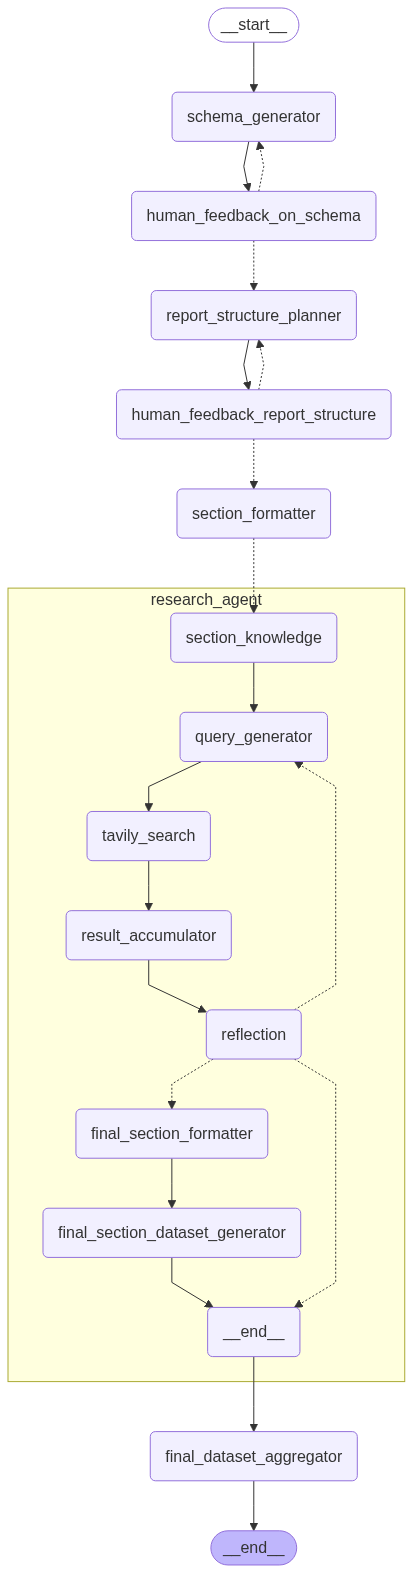

In [31]:
graph = builder.compile(checkpointer=memory_saver)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [33]:
import json
from datetime import datetime
import os

TOPIC = "Support Vector Machines"
OUTLINE = "I want to have qna dataset on this topic A-Z so that the model I train would be able to answer everythin about support vector machines"

thread = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
        "max_queries": 2,
        "search_depth": 1,
        "num_reflections": 2,
        "max_rows_from_each_section": 5
    }
}

for event in graph.stream(
    {"topic": TOPIC, "outline": OUTLINE},
    config=thread,
):
    if "schema_generator" in event:
        print("<<< SCHEMA GENERATOR >>>")
        print(event["schema_generator"]["schema"])
        print("\n", "="*100, "\n")
    elif "report_structure_planner" in event:
        print("<<< REPORT STRUCTURE PLANNER >>>")
        print(event["report_structure_planner"]["messages"][-1].content)
        print("\n", "="*100, "\n")
    elif "section_formatter" in event:
        print("<<< SECTION FORMATTING >>>")
        print(event["section_formatter"])
        print("\n", "="*100, "\n")
    elif "research_agent" in event:
        # check output of research_agent
        print("<<< RESEARCH AGENT >>>")
        print(event["research_agent"])
        print("\n", "="*100, "\n")
    elif "final_dataset_aggregator" in event:
        # check output of final_dataset_aggregator
        print("<<< FINAL REPORT WRITER >>>")
        print(event["final_dataset_aggregator"])
        print("\n", "=" * 100, "\n")

        # Save to file
        output_data = event["final_dataset_aggregator"]
        
        # Optional: create a timestamped filename or use a static one
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"final_dataset_output_{timestamp}.json"
        
        # Optional: save to a specific directory
        output_dir = "output_files"
        os.makedirs(output_dir, exist_ok=True)

        filepath = os.path.join(output_dir, filename)
        
        with open(filepath, "w", encoding="utf-8") as f:
            json.dump(output_data, f, indent=2, ensure_ascii=False)

        print(f"Saved final dataset to: {filepath}")
    elif "human_feedback_on_schema" in event:
        print("<<< HUMAN FEEDBACK ON SCHEMA >>>")
        print(event["human_feedback_on_schema"]["messages"][-1].content)
        print("\n", "="*100, "\n")
    elif "human_feedback_report_structure" in event:
        print("<<< HUMAN FEEDBACK ON REPORT STRUCTURE >>>")
        print(event["human_feedback_report_structure"]["messages"][-1].content)
        print("\n", "="*100, "\n")

<<< SCHEMA GENERATOR >>>
generated_schema=[SchemaField(key='question', type=<FieldType.string: 'string'>, description='The question related to Support Vector Machines that the model needs to answer.'), SchemaField(key='answer', type=<FieldType.string: 'string'>, description='The detailed answer or explanation regarding the question about Support Vector Machines.'), SchemaField(key='category', type=<FieldType.string: 'string'>, description='The category or subtopic under Support Vector Machines (e.g., theory, applications, algorithms, etc.).'), SchemaField(key='difficulty_level', type=<FieldType.string: 'string'>, description='The difficulty level of the question (e.g., easy, medium, hard).'), SchemaField(key='tags', type=<FieldType.array: 'array'>, description='A list of relevant tags associated with the question to help in categorization and retrieval.'), SchemaField(key='source', type=<FieldType.string: 'string'>, description='The source of the information or answer, such as a textbo

In [685]:
text = """# Understanding Support Vector Machines\n\n## Executive Summary\nSupport Vector Machines (SVMs) are a powerful class of supervised learning algorithms widely used for classification and regression tasks. This report explores the fundamentals of SVMs, their mathematical foundations, training processes, applications, advantages, limitations, and future directions. Key findings include the effectiveness of SVMs in high-dimensional spaces, their robustness against overfitting, and their versatility across various domains such as healthcare, finance, and image recognition. The report also addresses the challenges associated with SVMs, including computational complexity and sensitivity to parameter selection, while suggesting avenues for future research to enhance their capabilities.\n\n## Table of Contents\n1. Introduction  \n   1.1. Overview of Machine Learning  \n   1.2. Importance of Support Vector Machines  \n   1.3. Objectives of the Report  \n2. Fundamentals of Support Vector Machines  \n   2.1. Definition of Support Vector Machines  \n   2.2. Key Concepts  \n       2.2.1. Hyperplanes  \n       2.2.2. Support Vectors  \n       2.2.3. Margin  \n   2.3. Types of SVM  \n       2.3.1. Linear SVM  \n       2.3.2. Non-Linear SVM  \n3. Mathematical Foundations  \n   3.1. Optimization Problem  \n   3.2. Cost Function  \n   3.3. Kernel Trick  \n       3.3.1. Types of Kernels  \n           3.3.1.1. Linear Kernel  \n           3.3.1.2. Polynomial Kernel  \n           3.3.1.3. Radial Basis Function (RBF) Kernel  \n4. Training Support Vector Machines  \n   4.1. Data Preparation  \n   4.2. Training Process  \n   4.3. Model Evaluation  \n       4.3.1. Cross-Validation  \n       4.3.2. Performance Metrics  \n5. Applications of Support Vector Machines  \n   5.1. Classification Tasks  \n   5.2. Regression Tasks  \n   5.3. Anomaly Detection  \n   5.4. Real-World Use Cases  \n6. Advantages and Limitations of SVM  \n   6.1. Advantages  \n   6.2. Limitations  \n   6.3. Comparison with Other Machine Learning Algorithms  \n7. Conclusion  \n   7.1. Summary of Key Points  \n   7.2. Future Directions in SVM Research  \n8. References  \n   8.1. Academic Papers  \n   8.2. Books and Texts  \n   8.3. Online Resources  \n\n## 1. Introduction\n\n### 1.1. Overview of Machine Learning\nMachine learning (ML) has emerged as a transformative technology that empowers systems to learn from data and enhance their performance autonomously. This subset of artificial intelligence (AI) encompasses a wide array of algorithms and models designed to analyze and interpret complex datasets, facilitating informed decision-making across diverse domains. The significance of machine learning lies in its ability to extract actionable insights from vast amounts of data, driving advancements in sectors such as healthcare, finance, marketing, and autonomous systems.\n\n### 1.2. Importance of Support Vector Machines\nSupport Vector Machines (SVMs) represent a robust class of supervised learning algorithms particularly effective for classification tasks. The importance of SVMs can be attributed to their ability to manage high-dimensional data, their resilience against overfitting, and their effectiveness in both linear and non-linear classification scenarios. SVMs excel in high-dimensional spaces, making them suitable for applications such as image classification and bioinformatics.\n\n### 1.3. Objectives of the Report\nThis report aims to provide an in-depth exploration of Support Vector Machines, covering their fundamental principles, mathematical foundations, training processes, applications, advantages, limitations, and future research directions. By synthesizing existing knowledge and research, the report seeks to enhance understanding of SVMs and their role in modern machine learning.\n\n## 2. Fundamentals of Support Vector Machines\n\n### 2.1. Definition of Support Vector Machines\nSupport Vector Machines are defined as machine learning algorithms that aim to find the hyperplane which maximizes the margin between two classes of data points. The SVM algorithm\'s primary goal is to maximize the margin, which is the distance between the hyperplane and the nearest data points from each class, known as support vectors.\n\n### 2.2. Key Concepts\n\n#### 2.2.1. Hyperplanes\nA hyperplane serves as the decision boundary that separates different classes in the feature space. In a two-dimensional space, this hyperplane is a line, while in three dimensions, it becomes a plane.\n\n#### 2.2.2. Support Vectors\nSupport vectors are the data points that lie closest to the hyperplane. They are pivotal in defining both the margin and the hyperplane itself.\n\n#### 2.2.3. Margin\nThe margin is defined as the distance between the hyperplane and the nearest support vectors from either class. SVMs strive to maximize this margin, which enhances the model\'s ability to generalize to unseen data.\n\n### 2.3. Types of SVM\n\n#### 2.3.1. Linear SVM\nLinear SVMs are applicable when the data is linearly separable, meaning that a straight line (or hyperplane in higher dimensions) can effectively separate the classes.\n\n#### 2.3.2. Non-Linear SVM\nNon-Linear SVMs are employed when the data is not linearly separable. These models utilize kernel functions to map input features into a higher-dimensional space, allowing for the creation of a hyperplane that can effectively separate the classes.\n\n## 3. Mathematical Foundations\n\n### 3.1. Optimization Problem\nAt the heart of SVMs is the optimization problem, which seeks to identify the optimal hyperplane that maximizes the margin between different classes in the dataset. The optimization problem can be formulated with an objective function and constraints that ensure correct classification.\n\n### 3.2. Cost Function\nThe cost function quantifies the error in the model\'s predictions and guides the optimization algorithm toward the optimal hyperplane. It typically includes a regularization parameter that balances margin maximization and classification errors.\n\n### 3.3. Kernel Trick\nThe kernel trick is a powerful technique that enables SVMs to operate in higher-dimensional spaces without explicitly transforming the data. Common kernel functions include linear, polynomial, and radial basis function (RBF) kernels.\n\n#### 3.3.1. Types of Kernels\n\n##### 3.3.1.1. Linear Kernel\nSuitable for linearly separable data.\n\n##### 3.3.1.2. Polynomial Kernel\nAllows for polynomial decision boundaries.\n\n##### 3.3.1.3. Radial Basis Function (RBF) Kernel\nEffective for non-linear data distributions.\n\n## 4. Training Support Vector Machines\n\n### 4.1. Data Preparation\nData preparation is critical in the SVM training process, involving data collection, cleaning, feature selection, scaling, and splitting into training, validation, and test sets.\n\n### 4.2. Training Process\nThe training process involves selecting the kernel, setting hyperparameters, and optimizing the model to find the optimal hyperplane.\n\n### 4.3. Model Evaluation\n\n#### 4.3.1. Cross-Validation\nCross-validation techniques, such as K-Fold, ensure that the model is evaluated on different data segments.\n\n#### 4.3.2. Performance Metrics\nVarious metrics, including accuracy, precision, recall, F1 score, and AUC-ROC, are used to evaluate model performance.\n\n## 5. Applications of Support Vector Machines\n\n### 5.1. Classification Tasks\nSVMs are predominantly recognized for their prowess in classification problems, including text classification, image recognition, and bioinformatics.\n\n### 5.2. Regression Tasks\nSupport Vector Regression (SVR) is utilized to predict continuous outcomes, effectively modeling complex, non-linear relationships.\n\n### 5.3. Anomaly Detection\nSVMs are effective in identifying rare events or observations that deviate from the norm, particularly through one-class SVMs.\n\n### 5.4. Real-World Use Cases\nSVMs have applications across various industries, including healthcare for medical diagnosis, finance for credit scoring, and marketing for customer segmentation.\n\n## 6. Advantages and Limitations of SVM\n\n### 6.1. Advantages\nSVMs are effective in high-dimensional spaces, robust to overfitting, versatile through kernel functions, and grounded in strong theoretical foundations.\n\n### 6.2. Limitations\nChallenges include computational complexity, sensitivity to parameter selection, and difficulties with imbalanced data.\n\n### 6.3. Comparison with Other Machine Learning Algorithms\nSVMs are compared with decision trees, neural networks, k-nearest neighbors, logistic regression, and random forests, highlighting their strengths and weaknesses.\n\n## 7. Conclusion\n\n### 7.1. Summary of Key Points\nThis report has explored the foundational principles and operational mechanics of Support Vector Machines, emphasizing their significance in machine learning.\n\n### 7.2. Future Directions in SVM Research\nFuture research may focus on scalability improvements, hybrid models, kernel function innovations, unsupervised learning applications, real-time processing, and addressing ethical considerations in AI.\n\n## 8. References\n\n### 8.1. Academic Papers\n1. Cortes, C., & Vapnik, V. (1995). "Support-Vector Networks." Machine Learning, 20(3), 273-297.\n2. Schölkopf, B., & Smola, A. J. (2002). "Learning with Kernels: Support Vector Machines, Regularization, Optimization, and Beyond." MIT Press.\n3. Boser, B. E., Guyon, I. M., & Vapnik, V. N. (1992). "A Training Algorithm for Optimal Margin Classifiers." Proceedings of the Fifth Annual Workshop on Computational Learning Theory, 144-152.\n4. Zhang, T., & Yu, B. (2005). "Boosting with Adversarial Examples." Proceedings of the 22nd International Conference on Machine Learning (ICML).\n5. Cervantes, J., et al. (2020). "A Comprehensive Survey on Support Vector Machines: Applications, Challenges, and Trends."\n6. Guido, S., et al. (2024). "Advancements of SVM Models in Healthcare Applications."\n\n### 8.2. Books and Texts\n1. Vapnik, V. (1998). "Statistical Learning Theory." Wiley.\n2. Hastie, T., Tibshirani, R., & Friedman, J. (2009). "The Elements of Statistical Learning: Data Mining, Inference, and Prediction." Springer.\n3. Cristianini, N., & Shawe-Taylor, J. (2000). "An Introduction to Support Vector Machines and Other Kernel-Based Learning Methods." Cambridge University Press.\n4. Bishop, C. M. (2006). "Pattern Recognition and Machine Learning." Springer.\n5. Boyd, S., & Vandenberghe, L. (2004). "Convex Optimization."\n6. Kowalczyk, A. (2017). "Support Vector Machines Succinctly."\n\n### 8.3. Online Resources\n1. The LIBSVM Library (https://www.csie.ntu.edu.tw/~cjlin/libsvm/)\n2. Scikit-learn Documentation (https://scikit-learn.org/stable/modules/svm.html)\n3. Coursera Course: "Machine Learning" by Andrew Ng (https://www.coursera.org/learn/machine-learning)\n4. Towards Data Science Articles (https://towardsdatascience.com/)\n\nThis comprehensive report on Support Vector Machines provides a detailed understanding of their principles, applications, and future directions, serving as a valuable resource for researchers and practitioners in the field of machine learning."""

In [ ]:
print(text)

# Understanding Support Vector Machines

## Executive Summary
Support Vector Machines (SVMs) are a powerful class of supervised learning algorithms widely used for classification and regression tasks. This report explores the fundamentals of SVMs, their mathematical foundations, training processes, applications, advantages, limitations, and future directions. Key findings include the effectiveness of SVMs in high-dimensional spaces, their robustness against overfitting, and their versatility across various domains such as healthcare, finance, and image recognition. The report also addresses the challenges associated with SVMs, including computational complexity and sensitivity to parameter selection, while suggesting avenues for future research to enhance their capabilities.

## Table of Contents
1. Introduction  
   1.1. Overview of Machine Learning  
   1.2. Importance of Support Vector Machines  
   1.3. Objectives of the Report  
2. Fundamentals of Support Vector Machines  
   2.1.